In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
%matplotlib inline
%load_ext sql
%config SqlMagic.autopandas = True

In [3]:
%sql postgresql://localhost/bankcalls

'Connected: @bankcalls'

# Let's start with how many yes/nos we have

In [4]:
%%sql
SELECT success, COUNT(*) 
FROM bank_addl
GROUP BY success;

 * postgresql://localhost/bankcalls
2 rows affected.


,success,count
0,no,36548
1,yes,4640


In [5]:
# This just grabs the output of a %%sql cell
# (I'm in autopandas mode so it's a DataFrame)
df = _

,success,count,pct
0,no,36548,88.734583
1,yes,4640,11.265417


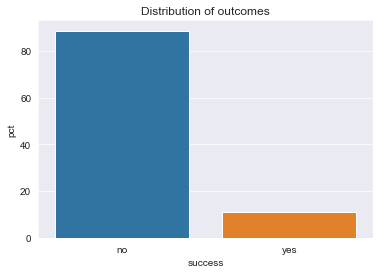

In [6]:
df['pct'] = 100.0 * df['count'] / np.sum(df['count'])
sns.barplot(x='success', y='pct', data=df )
plt.title("Distribution of outcomes")
df

In [7]:
success_pct = df.query("success == 'yes'").pct.iloc[0]

# How do the various categeorical columns chart vs success?

In [8]:
%%sql 
SELECT 
    column_name
FROM 
    information_schema.columns 
WHERE
    table_name='bank_addl' 
    AND
    column_name != 'success' 
    AND
    data_type = 'character varying';

 * postgresql://localhost/bankcalls
10 rows affected.


,column_name
0,job
1,marital
2,education
3,in_default
4,housing
5,loan
6,contact
7,month
8,day_of_week
9,poutcome


In [9]:
categorical = _.column_name

 * postgresql://localhost/bankcalls
24 rows affected.


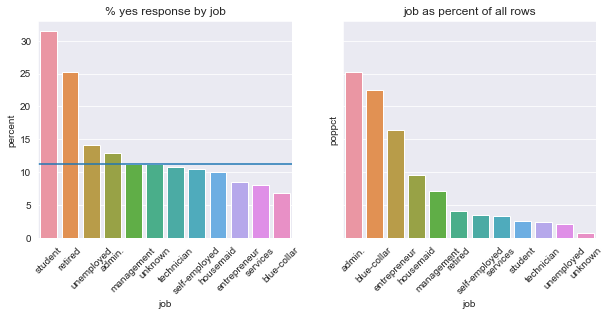

 * postgresql://localhost/bankcalls
8 rows affected.


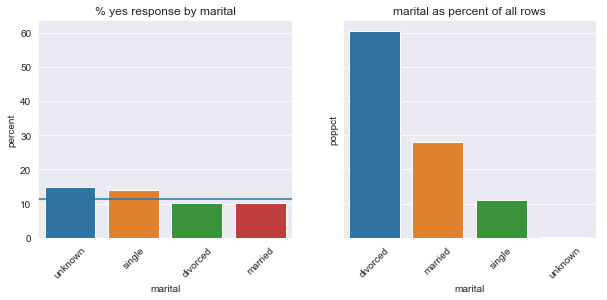

 * postgresql://localhost/bankcalls
16 rows affected.


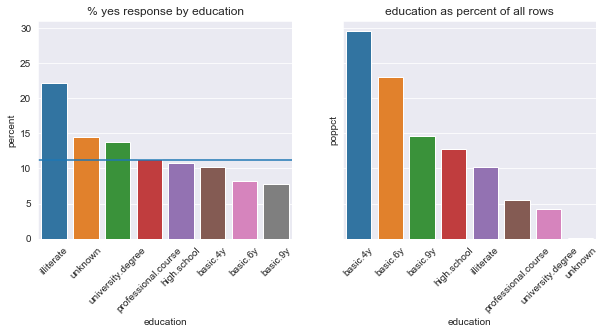

 * postgresql://localhost/bankcalls
5 rows affected.


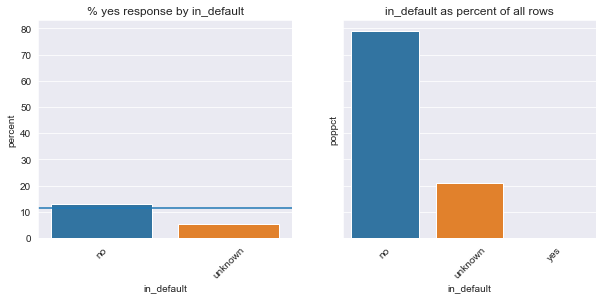

 * postgresql://localhost/bankcalls
6 rows affected.


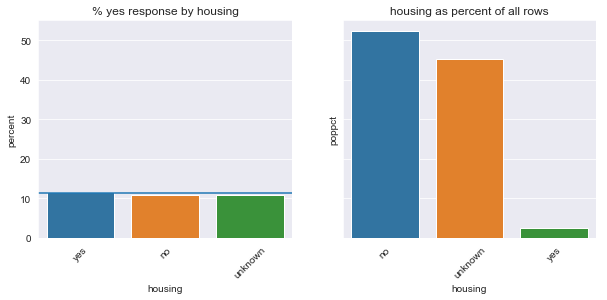

 * postgresql://localhost/bankcalls
6 rows affected.


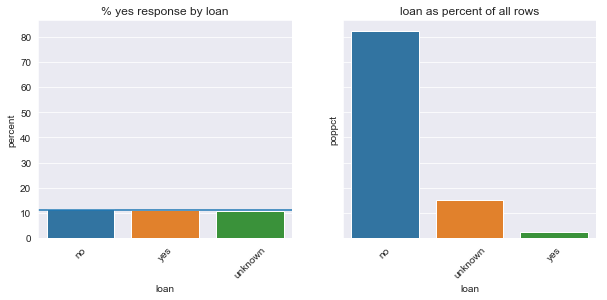

 * postgresql://localhost/bankcalls
4 rows affected.


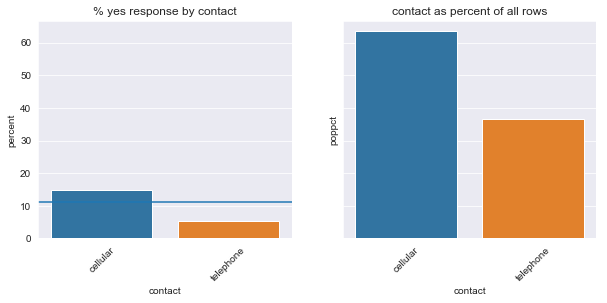

 * postgresql://localhost/bankcalls
20 rows affected.


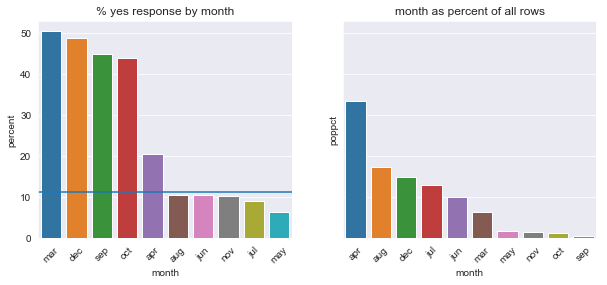

 * postgresql://localhost/bankcalls
10 rows affected.


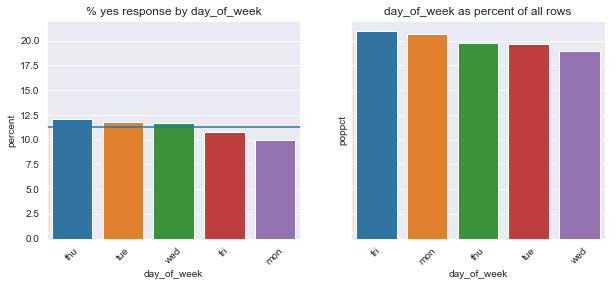

 * postgresql://localhost/bankcalls
6 rows affected.


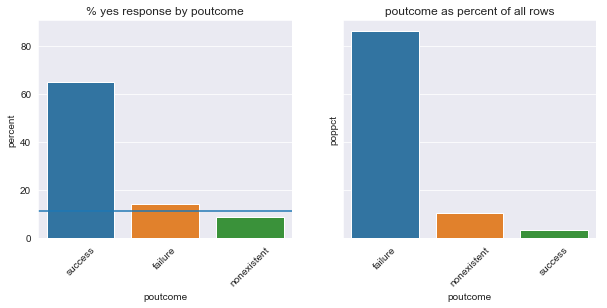

In [10]:
for c in categorical:
    
    # WARNING: The select COUNT(*) names the column "count" which stomps on 
    # dataframe.count. Renamed to cnt here.
    
    # Count up the number in each value of the category that said yes and no
    df = %sql SELECT success, $c, COUNT($c) cnt FROM bank_addl GROUP BY $c, success ORDER BY $c; 
    
    # Count up the yes+no value for each category as denominator for left chart
    category_sum = df.groupby(c).sum()
    
    # And the sum of all categories and responses as denominator for right chart
    population_sum = category_sum.sum()
    
    # Calculate what percent of each categorical value said yes versus no
    # and plot on the left side
    df['percent'] = -1.0
    for value in df[c].unique():
        index_vector = (df.loc[:,c] == value)
        df.loc[index_vector,'percent'] = (100.0 * 
                    df.loc[index_vector, 'cnt'].astype(float) / 
                    category_sum.loc[value,'cnt'].astype(float))
    
    fig, axs = plt.subplots(nrows=1,  ncols=2, 
            sharex=False, sharey=True, 
            squeeze=True, figsize=(10,4))
    
    # Sort by the most yes'es
    data=df.query("success == 'yes'")
    data=data.sort_values(by=['percent'], axis=0, ascending=False)
    sns.barplot(x=c, y='percent', ax=axs[0], data=data)
    axs[0].set_title("% yes response by " + c)
    for tick in axs[0].get_xticklabels():
        tick.set_rotation(45)
    xmin,xmax = axs[0].get_xlim()
    axs[0].axhline(success_pct, xmin, xmax)
        
    # Calculate what percent of the population each categorical value represents
    # and plot that on the right side (i.e. if a high percent of retired people
    # bought the product, that is more helpful if retired people are a large percent
    # of the customer database.
        
    category_sum['poppct'] = -1.0
    for value in df[c].unique():
        category_sum.loc[value, 'poppct'] = (100.0 * 
                              category_sum.loc[value,'cnt'].astype(float)/
                              population_sum['cnt'].astype(float))
    sns.barplot(x=category_sum.index, 
                y='poppct', 
                data=category_sum.sort_values(by=['poppct'], ascending=False), 
                ax=axs[1])
    axs[1].set_title(c + " as percent of all rows")
    for tick in axs[1].get_xticklabels():
        tick.set_rotation(45)
        
    plt.show()

# How do numerical predictors chart with success

 * postgresql://localhost/bankcalls
41188 rows affected.


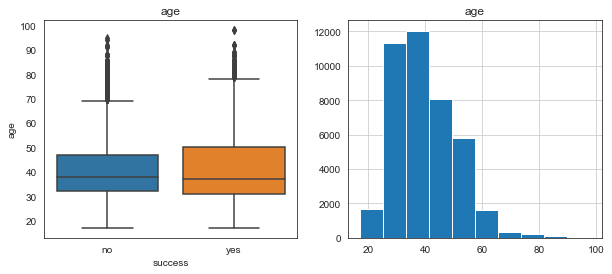

 * postgresql://localhost/bankcalls
41188 rows affected.


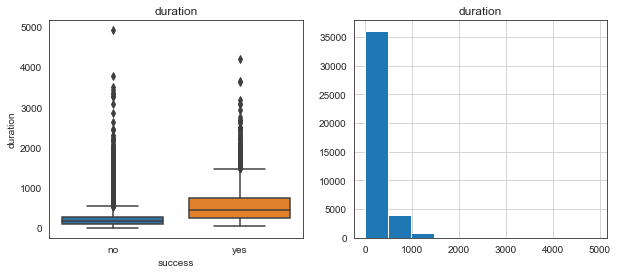

 * postgresql://localhost/bankcalls
41188 rows affected.


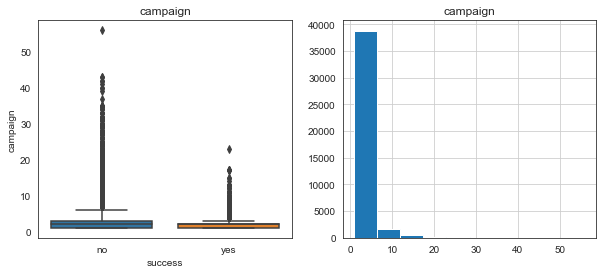

 * postgresql://localhost/bankcalls
41188 rows affected.


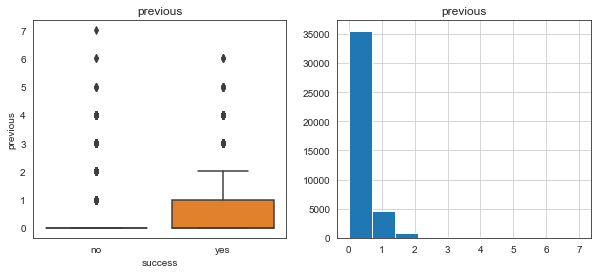

 * postgresql://localhost/bankcalls
41188 rows affected.


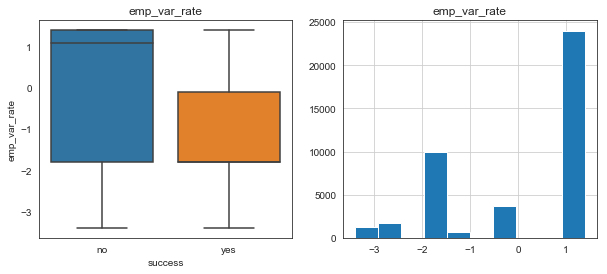

 * postgresql://localhost/bankcalls
41188 rows affected.


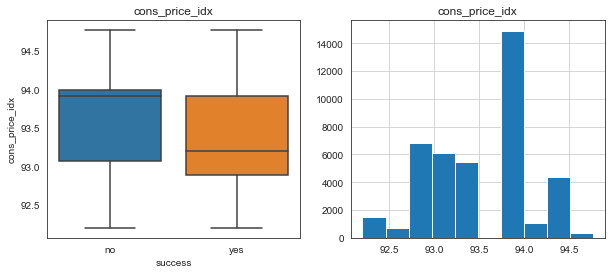

 * postgresql://localhost/bankcalls
41188 rows affected.


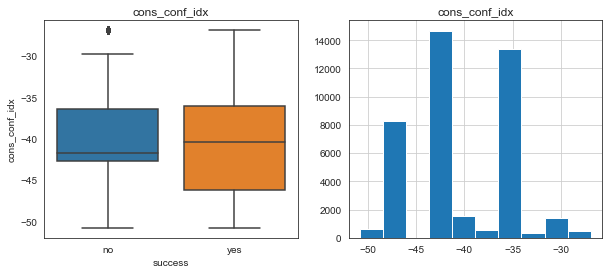

 * postgresql://localhost/bankcalls
41188 rows affected.


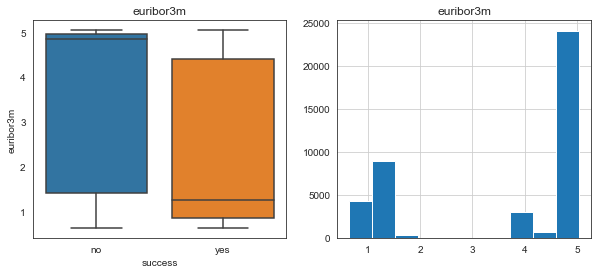

 * postgresql://localhost/bankcalls
41188 rows affected.


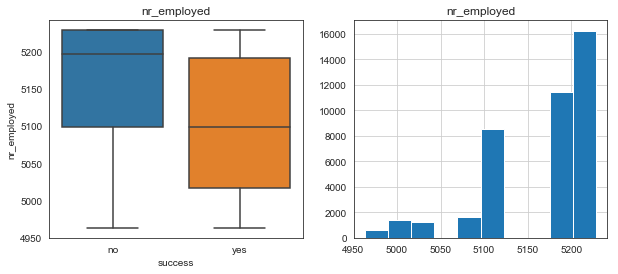

 * postgresql://localhost/bankcalls
41188 rows affected.


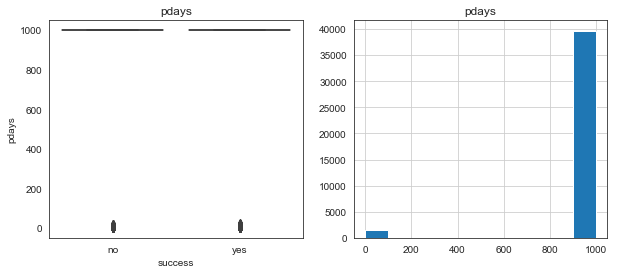

In [29]:
numerical_predictors = [ 
    'age', 'duration', 'campaign', 'previous',
    'emp_var_rate', 'cons_price_idx', 
    'cons_conf_idx', 'euribor3m', 'nr_employed', 'pdays'
]
sns.set_style('white')

for col in numerical_predictors:
    df = %sql SELECT $col, success from bank_addl;
    
    fig, axs = plt.subplots(nrows=1, ncols=2, 
                    sharex=False, sharey=False, squeeze=True,
                    figsize=(10,4))
    
    ax = sns.boxplot(x='success', y=col, data=df, ax=axs[0])
    ax.set_title(col)
    
    df[col].hist(ax=axs[1]).set_title(col)
    
    plt.show()

### Campaign - how many phone calls during the current campaign

In [12]:
df = %sql select campaign from bank_addl;
df.describe()

 * postgresql://localhost/bankcalls
41188 rows affected.


,campaign
count,41188.000000
mean,2.567593
std,2.770014
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,56.000000


In [21]:
df.query('campaign >3').shape

(7635, 1)

It looks like some poor folks did get called 56 times! 

In [22]:
df = %sql select previous from bank_addl;
df.describe()

 * postgresql://localhost/bankcalls
41188 rows affected.


,previous
count,41188.000000
mean,0.172963
std,0.494901
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,7.000000


In [23]:
df.previous.value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

### Anything collinear in the economic terms?

In [13]:
econ  = [  'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed' ]
corr_mat = pd.DataFrame(index=econ)
while len(econ) >= 2:
    col1 = econ[0]
    corrs = [ 'corr(' + col1 + ',' + e + ') as ' + e for e in econ ]
    command = ", ".join(corrs) 
    corr_mat_column = %sql select $command from bank_addl;
    corr_mat_column.index = [col1]
    corr_mat = pd.concat([corr_mat, corr_mat_column.T], axis=1, sort=False)
    econ = econ[1:]

 * postgresql://localhost/bankcalls
1 rows affected.
 * postgresql://localhost/bankcalls
1 rows affected.
 * postgresql://localhost/bankcalls
1 rows affected.
 * postgresql://localhost/bankcalls
1 rows affected.


In [14]:
corr_mat.round(decimals=3)

,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m
emp_var_rate,1.000,NaN,NaN,NaN
cons_price_idx,0.775,1.000,NaN,NaN
cons_conf_idx,0.196,0.059,1.000,NaN
euribor3m,0.972,0.688,0.278,1.000
nr_employed,0.907,0.522,0.101,0.945


There is quite a bit of correlation in number employed, employment variation rate, and euribor 3 month interest rate.

# Summary of EDA

In the categorical variables, students and the retired seem to be more likely to choose the term deposit option. Education level "illiterate" seems more responsive
as well. These demographics may be more interested in a simple and conservative investment
like a bank deposit account. However, these categories are only 5 to 10 percent
of the total population of bank customers.

If the customer has a loan in default, there is no reason to market deposit opportunities to them. (They may have no money to deposit if they are behind in their loan.)

Contacting people by cell phone seems to work well. 

Some clear seasonality in response rates. The bank made the most number of calls in April, but got the highest response rates in March, December, September, and October. The bank should consider
making more calls during the months with higher success rates. In particular,
calling customers who have been successful sales in the past, during the months
of peak demand seems like a promising strategy.

Although the data was supposedly colleged from May, 2008 to November 2010, there are only 10 months represented in the data. Apparently the bank does not run this marketing campaign in January and February? Also the bank only accepts term deposits on weekdays; there are no
calls on Saturday and Sunday. 

The mid-50% 'yes' responses are overrepresented over the lower ranges of the economic indicators. It seems that
more people want the safety of a bank deposit account during times of 
financial uncertainty. This suggests that a certain portion of the response
rate is out of the bank's control. If the economy is doing well, there 
may be fewer customers for this product no matter what marketing strategy
is used. 

An alternative strategy might be to examine what customers 
want in different circumstances and sell a product that meets the needs
of the moment. When the term deposit campaign is working
well, keep running it. When it's not, then 
maybe use the telemarketing resources to sell a different product that matches the current state of the economy better.

Three of the economic indicators -- nr_employed, emp_var_rate, and euribor3m are
highly correlated. Care must be used when incorporating all three into the same model.